In [1]:
%load_ext autoreload
%autoreload 2

Import dependencies

In [2]:
from haystack import Document, Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

Initialize components

In [3]:
document_store = InMemoryDocumentStore(embedding_similarity_function="cosine")
text_embedder = SentenceTransformersTextEmbedder()  # type: ignore
retriever = InMemoryEmbeddingRetriever(document_store=document_store)  # type: ignore

Create the pipeline

In [4]:
query_pipeline = Pipeline()

Add components

In [5]:
query_pipeline.add_component("text_embedder", text_embedder)
query_pipeline.add_component("retriever", retriever)

Connect components

In [6]:
query_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")

# Because the InMemoryEmbeddingRetriever only has one input, this is also correct:
# pipeline.connect("text_embedder.embedding", "retriever")

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])

Run the pipeline

In [7]:
results = query_pipeline.run({
    "text_embedder": {
        "text": "How is the weather today?"
    }
})

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

No Documents found with embeddings. Returning empty list. To generate embeddings, use a DocumentEmbedder.


In [8]:
results

{'retriever': {'documents': []}}

Pipeline input

In [9]:
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.components.writers import DocumentWriter

In [10]:
document_store = InMemoryDocumentStore()
fetcher = LinkContentFetcher()  # type: ignore
converter = HTMLToDocument()  # type: ignore
writer = DocumentWriter(document_store = document_store)  # type: ignore

In [11]:
pipeline = Pipeline()
pipeline.add_component(instance=fetcher, name="fetcher")
pipeline.add_component(instance=converter, name="converter")
pipeline.add_component(instance=writer, name="writer")

In [12]:
pipeline.connect("fetcher.streams", "converter.sources")
pipeline.connect("converter.documents", "writer.documents")

🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - writer: DocumentWriter
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> writer.documents (List[Document])

In [13]:
# Requesting a list of required inputs
pipeline.inputs()

{'fetcher': {'urls': {'type': typing.List[str], 'is_mandatory': True}},
 'converter': {'meta': {'type': typing.Union[typing.Dict[str, typing.Any], typing.List[typing.Dict[str, typing.Any]], NoneType],
   'is_mandatory': False,
   'default_value': None},
  'extraction_kwargs': {'type': typing.Optional[typing.Dict[str, typing.Any]],
   'is_mandatory': False,
   'default_value': None}},
 'writer': {'policy': {'type': typing.Optional[haystack.document_stores.types.policy.DuplicatePolicy],
   'is_mandatory': False,
   'default_value': None}}}

In [14]:
pipeline.run(data={
    "fetcher": {
        "urls": ["https://docs.vngcloud.vn/vng-cloud-document"]
        }
    })

{'writer': {'documents_written': 1}}

In [15]:
document_store.save_to_disk("vngcloud_docs")

Visuzlizing pipelines

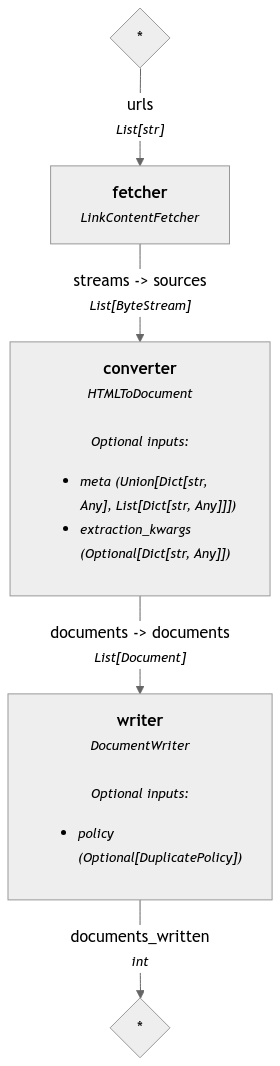

In [16]:
pipeline.show()

Save the graph to a file

In [17]:
pipeline.draw(path="my_pipeline.png")

Convert pipeline to YAML file

In [18]:
print(pipeline.dumps())

components:
  converter:
    init_parameters:
      extraction_kwargs: {}
      store_full_path: true
    type: haystack.components.converters.html.HTMLToDocument
  fetcher:
    init_parameters:
      raise_on_failure: true
      retry_attempts: 2
      timeout: 3
      user_agents:
      - haystack/LinkContentFetcher/2.8.0
    type: haystack.components.fetchers.link_content.LinkContentFetcher
  writer:
    init_parameters:
      document_store:
        init_parameters:
          bm25_algorithm: BM25L
          bm25_parameters: {}
          bm25_tokenization_regex: (?u)\b\w\w+\b
          embedding_similarity_function: dot_product
          index: 1972e936-bdac-49de-93b2-ea3320f7a953
        type: haystack.document_stores.in_memory.document_store.InMemoryDocumentStore
      policy: NONE
    type: haystack.components.writers.document_writer.DocumentWriter
connections:
- receiver: converter.sources
  sender: fetcher.streams
- receiver: writer.documents
  sender: converter.documents
max_r

In [19]:
with open("my_pipeline.yaml", "w") as f:
    pipeline.dump(f)

Convert pipeline back to Python code

In [20]:
from haystack.core.serialization import DeserializationCallbacks
from typing import Type, Dict, Any

In [21]:
# This is the YAML you want to convert to Python:
pipeline_yaml = """
components:
  cleaner:
    init_parameters:
      remove_empty_lines: true
      remove_extra_whitespaces: true
      remove_regex: null
      remove_repeated_substrings: false
      remove_substrings: null
    type: haystack.components.preprocessors.document_cleaner.DocumentCleaner
  converter:
    init_parameters:
      encoding: utf-8
    type: haystack.components.converters.txt.TextFileToDocument
connections:
- receiver: cleaner.documents
  sender: converter.documents
max_loops_allowed: 100
metadata: {}
"""

In [22]:
def component_pre_init_callback(component_name: str, component_cls: Type, init_params: Dict[str, Any]):
    # This function gets called every time a component is deserialized.
    if component_name == "cleaner":
        assert "DocumentCleaner" in component_cls.__name__
        # Modify the init parameters. The modified parameters are passed to
        # the init method of the component during deserialization.
        init_params["remove_empty_lines"] = False
        print("Modified 'remove_empty_lines' to False in 'cleaner' component")
    else:
        print(f"Not modifying component {component_name} of class {component_cls}")

In [23]:
pipe = Pipeline.loads(pipeline_yaml, callbacks=DeserializationCallbacks(component_pre_init_callback))

Modified 'remove_empty_lines' to False in 'cleaner' component
Not modifying component converter of class <class 'haystack.components.converters.txt.TextFileToDocument'>
